Install missing required packages

In [1]:
!conda install -c conda-forge xgboost shap -y



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda


Did not find path entry C:\Users\gu01042270\Anaconda3\bin



Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gu01042270\Anaconda3

  added / updated specs:
    - shap
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    conda-4.10.3               |   py38haa244fe_2         3.1 MB  conda-forge
    libxgboost-1.4.2           |       h0e60522_0         2.1 MB  conda-forge
    py-xgboost-1.4.2           |   py38haa244fe_0         141 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    shap-0.39.0                |   py38h60cbd38_0         543 KB  conda-forge
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    xgboost-1.4.2              |   py38haa244fe_0          11 KB  conda-forge
    -----------------------------------------------------------

Import packages used throughout notebook

In [16]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# Utility Functions

## Data Preparation
We are going to create a function that splits our data into a training set and a test set. 80% of the data will be the training set and 20% will be the test set.

In [3]:
from sklearn.model_selection import train_test_split
def prepare_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    # Seperate the predictor variables (X) from the target variable (y) and into their own dataframes

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Create a training and test set for the predictor and target variables

    return X_train, X_test, y_train, y_test

## Model Evaluation
We also want to create a function to automatically evaluate the model. We will be looking at accuracy, recall, percision, f1-score, confusion matrix and the ROC Curve

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    # accuracy = correct_predictions / all_predictions 
    acc = accuracy_score(y_test, pred)

    # true_positives / (true_positives + false_postives)
    # how many positive predictions were true
    prec = precision_score(y_test, pred, average='weighted')

    # true_postives / (true_positives + false_negatives)
    # how many postives out of all were identified
    rec = recall_score(y_test, pred, average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, pred, average='weighted')
    
    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1: {f1}")
    
    try:
        prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, prob, multi_class='ovo')
        print(f"roc_auc: {roc_auc}")
    except:
        pass
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, X_test, y_test, xticks_rotation='vertical', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Actual labels')

    
    

## Model Evaluation with Naive Rule
We want to understand what the accuracy of a Naive Rule Model is, so we create a simple function to get us the accuracy for it. This is a simple and effective way to rule out any ML model that does not make value adding predictions.

In [5]:
def naive_rule_accuracy(y_train,y_test):
    training_count = y_train.value_counts()

    unique_class = pd.unique(y_train)

    for i in unique_class:
        if training_count[i] == training_count.max():
            majority_class = i

    test_count = y_test.value_counts()
    accuracy_naive = test_count[majority_class]/test_count.sum()

    print(f"The accuracy of the Naive Model is: {accuracy_naive}")

# Regression

## Data Preparation
We will load in our salary data and name the dataframe salary_data. We will also see what the data looks like by typing in our dataframe name on the line beneath the code to load in the data. This way we can get a snippet of the data to understand what it looks like. Run the cell below to load in the salary data and see what the data looks like.

In [6]:
salary_data = pd.read_csv('Salary.csv')
salary_data

,Profession,Rank,Equipment,Insalubrity,Size_Production,Salary
0,Metal heater,7,Heating furnaces,22,580,26020.00000
1,Metal heater,6,Heating furnaces,22,580,22980.00000
2,Metal heater,5,Heating furnaces,22,580,20350.00000
3,Metal heater,5,Heating furnaces,22,580,20350.00000
4,Metal heater,4,Heating furnaces,22,580,18090.00000
...,...,...,...,...,...,...
259,Quality controller,7,Control and measuring equipment,0,1180,26342.23529
260,Quality controller,7,Control and measuring equipment,0,1080,25044.58824
261,Quality controller,7,Control and measuring equipment,0,780,22060.00000
262,Quality controller,7,Control and measuring equipment,0,1020,24266.00000


## Categorical Encoding
Now we will use Label Encoding to convert our categorical variables (Profession and Equipment) to numerical variables. This is done so the ML model can make sense of the categorical variables. Run the cell below to categorically encode these variables and see what the dataset looks like after.

In [7]:
from sklearn.preprocessing import LabelEncoder
profession_encoder = LabelEncoder()
salary_data['Profession'] = profession_encoder.fit_transform(salary_data['Profession'])

equipment_encoder = LabelEncoder()
salary_data['Equipment'] = equipment_encoder.fit_transform(salary_data['Equipment'])

salary_data

,Profession,Rank,Equipment,Insalubrity,Size_Production,Salary
0,2,7,2,22,580,26020.00000
1,2,6,2,22,580,22980.00000
2,2,5,2,22,580,20350.00000
3,2,5,2,22,580,20350.00000
4,2,4,2,22,580,18090.00000
...,...,...,...,...,...,...
259,5,7,1,0,1180,26342.23529
260,5,7,1,0,1080,25044.58824
261,5,7,1,0,780,22060.00000
262,5,7,1,0,1020,24266.00000


## Splitting Data
Now we will prepare our data by splitting it into training and test sets using the function we made earlier. In order to understand exactly what this function does, we will also see what the X_Train, Y_Train, X_Test, Y_Test datasets in that order. You will notice that the X_train and X_test datasets are all the predictor variables and the Y_test and Y_train datset is the target variable (Salary)

In [33]:
X_train, X_test, y_train, y_test = prepare_data(salary_data, 'Salary')
display(X_train,y_train,X_test,y_test)

,Profession,Rank,Equipment,Insalubrity,Size_Production
244,0,3,0,0,1250
115,0,3,4,18,950
207,7,7,3,18,1020
140,2,7,2,22,1180
153,8,3,4,18,1180
...,...,...,...,...,...
226,6,4,2,11,810
5,3,4,2,22,580
231,7,6,4,18,810
149,8,4,3,18,1180


244    15045.88235
115    16136.47059
207    27506.00000
140    30302.23529
153    17784.35294
          ...     
226    16110.00000
5      18090.00000
231    22260.00000
149    20112.88235
18     17830.00000
Name: Salary, Length: 211, dtype: float64

,Profession,Rank,Equipment,Insalubrity,Size_Production
159,4,4,5,8,1180
158,4,5,5,8,1180
160,2,7,2,22,1080
110,7,7,4,18,950
131,7,6,4,18,1400
229,8,4,3,18,810
31,7,6,4,18,790
242,0,3,0,0,820
239,4,4,5,8,810
134,1,4,4,16,1400


159    18312.88235
158    21011.58824
160    29004.58824
110    26597.64706
131    28413.52941
229    17370.00000
31     22260.00000
242    12180.00000
239    15570.00000
134    21581.47059
96     23486.47059
99     18894.70588
35     15420.00000
2      20350.00000
144    20832.88235
247    14544.35294
86     19434.70588
60     30561.76471
201    24882.00000
152    20112.88235
234    17010.00000
8      22260.00000
107    26597.64706
50     25300.00000
232    17370.00000
248    13827.88235
49     17370.00000
255    26601.76471
183    20350.00000
17     17830.00000
237    17830.00000
263    22060.00000
253    22060.00000
172    19281.70588
258    29197.05882
213    16638.00000
120    33157.05882
41     22980.00000
261    22060.00000
165    20001.70588
145    20832.88235
157    21011.58824
174    18921.70588
192    17370.00000
55     15420.00000
218    19469.00000
188    22260.00000
121    29133.52941
203    21989.00000
190    25300.00000
113    16136.47059
198    17830.00000
117    18794

## Linear Regression Model
Now we will run a linear regression model on our prepared dataset below. We will evaluate this model with 4 metrics: mean absolute error, mean squared error, root mean squared error and the R2 score. Run the cell below to get these 4 metrics

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

coef = model.coef_
intercept = model.intercept_
cols = X_train.columns

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2: {r2}")
print(f"\nEquation for Regression Model:")
print(f"Salary = {coef[0]}({cols[0]}) + {coef[1]}({cols[1]}) + {coef[2]}({cols[2]}) + {coef[3]}({cols[3]}) + {coef[4]}({cols[4]})")

Mean Absolute Error: 539.2878797623194
Mean Squared Error: 482020.14226162597
Root Mean Squared Error: 694.2767043921508
R2: 0.9766172320528823

Equation for Regression Model:
Salary = 20.135422640296902(Profession) + 2739.5102301289535(Rank) + -60.9959797037148(Equipment) + 167.43064775948233(Insalubrity) + 7.2237963287160145(Size_Production)


# Binary Classification (Rice data)

## Data Preperation
Like all the previous dataset we will load in our rice data as rice_data. We will use this dataset to predict if the rice is Jasmine or is Gonen. (1 = Jasmine, 0 = Gonen). We will load in the data and then split it into training and test sets. 

In [45]:
rice_data = pd.read_csv('rice.csv')
rice_data

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229317,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [46]:
X_train, X_test, y_train, y_test = prepare_data(rice_data, 'Class')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further.

In [47]:
naive_rule_accuracy(y_train,y_test)

The accuracy of the Naive Model is: 0.5562276601594721


## Logistic Regression Model
Now lets run a Logistic Regression Model and produce some evaluation metrics and the confusion matrix.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.9906516359637063
precision: 0.9906807978978798
recall: 0.9906516359637063
f1: 0.9906467637192178


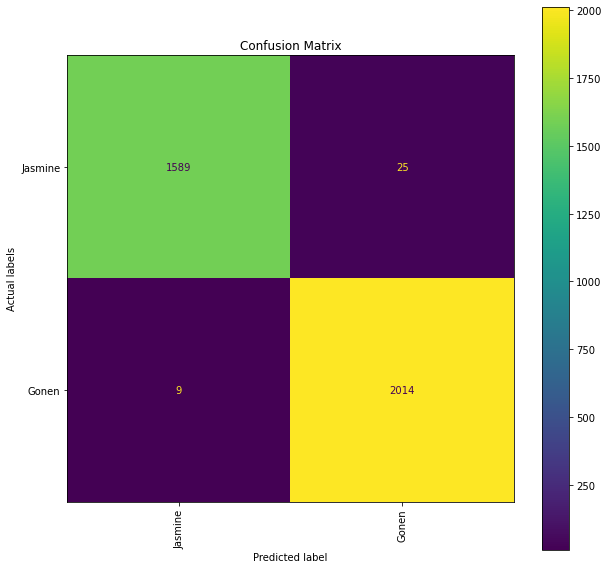

In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

fig = plt.gcf()
ax = plt.gca()

ax.xaxis.set_ticklabels(['Jasmine','Gonen']); ax.yaxis.set_ticklabels(['Jasmine','Gonen']);

By running the cell below we will find the amount of false positives and false negatives.

In [14]:
pred = model.predict(X_test)
false_positives = 0
false_negatives = 0
for prediction, truth in zip(pred, y_test):
    if truth == 1 and prediction == 0:
        false_negatives += 1
    if truth == 0 and prediction == 1:
        false_positives += 1

print(f"False Positives: {false_positives}")
print(f"False negatives: {false_negatives}")

False Positives: 42
False negatives: 14


The cell below display's the ROC_AUC score and graph.

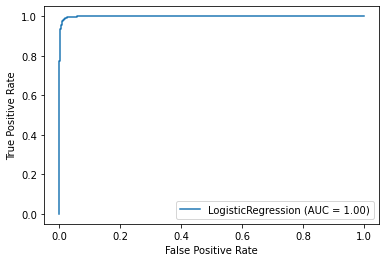

In [15]:
from sklearn.metrics import roc_curve, plot_roc_curve
roc_curve(y_test, model.predict_proba(X_test)[:,1])
plot_roc_curve(model, X_test, y_test)

# Binary Classification (Credit)

## Data Preperation
We will now look at credit data for another Binary Classification problem. We will load in the data as credit_data, veiw it and then split it similarly to the rice dataset. For this dataset we will be looking at payment history patterns for customers (the CustomerID field has been removed for anonymity) and try to predict if they will be credit risks or not.

In [25]:
credit_data = pd.read_csv('Company.csv')
credit_data

,Company Code,MPD_AUG_2021,MPD_JUL_2021,MPD_JUN_2021,MPD_MAY_2021,MPD_APR_2021,MPD_MAR_2021,MPD_FEB_2021,MPD_JAN_2021,Average_Payment_Days,"('total_counts', '0')","('total_counts', '1-30')","('total_counts', '31-60')","('total_counts', '61-90')","('total_counts', '90+')",Risk
0,1001,0,0,0,0,0,8,0,0,8,0,1,0,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1001,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1001,0,0,0,0,0,15,0,0,15,0,1,0,0,0,0
4,2001,0,0,0,0,0,0,0,0,113,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103771,8200,20,0,22,0,0,0,0,0,21,2,7,7,0,0,0
103772,8200,7,7,27,10,0,0,0,0,13,2,16,4,0,0,0
103773,8200,0,0,0,26,0,0,0,0,26,0,1,0,0,0,0
103774,8200,0,15,26,0,0,0,0,0,20,2,6,3,0,0,0


In [27]:
X_train, X_test, y_train, y_test = prepare_data(credit_data, 'Risk')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further.

In [28]:
naive_rule_accuracy(y_train,y_test)

The accuracy of the Naive Model is: 0.813596068606668


# Logistic Regression Model
Now lets run the model, like we did above and see if we get an improved output from the naive rule.

C:\Users\gu01042270\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.9167951435729428
precision: 0.9148265486960073
recall: 0.9167951435729428
f1: 0.9155432324632365


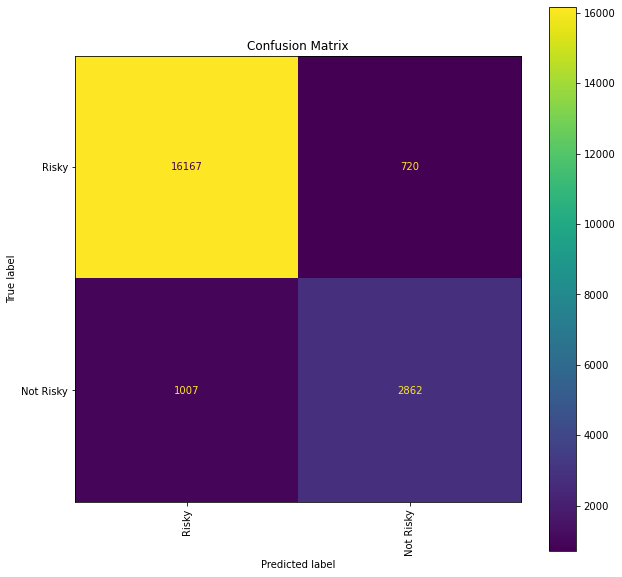

In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

fig = plt.gcf()
ax = plt.gca()

ax.xaxis.set_ticklabels(['Risky','Not Risky']); ax.yaxis.set_ticklabels(['Risky','Not Risky']);

Run the cell below to see how many false positives and false negatives there were

In [31]:
pred = model.predict(X_test)
false_positives = 0
false_negatives = 0
for prediction, truth in zip(pred, y_test):
    if truth == 1 and prediction == 0:
        false_negatives += 1
    if truth == 0 and prediction == 1:
        false_positives += 1

print(f"False Positives: {false_positives}")
print(f"False negatives: {false_negatives}")

False Positives: 720
False negatives: 1007


Run the cell below to see what the ROC_AUC score was

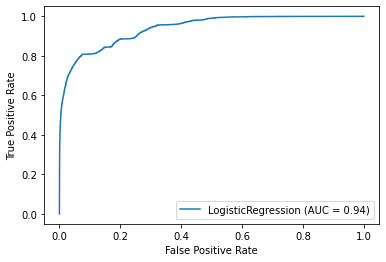

In [32]:
from sklearn.metrics import roc_curve, plot_roc_curve
roc_curve(y_test, model.predict_proba(X_test)[:,1])
plot_roc_curve(model, X_test, y_test)

# Classification (Crop Recommendation)

## Data Preparation
Now we will import the crop.csv dataset as crop_data. We will use this dataset to better predict the 'label' colunm. Run the cell below to see what the dataset looks like after it has been loaded.

In [ ]:
crop_data = pd.read_csv('crops.csv')
crop_data

Just like the heart dataset, we will now split this dataset into training and test sets. If you would like to see what these datasets look like, run the cell, open another cell below them and type in the name(s) of the dataset(s) you wish to see (see similar example with heart_data above).

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

## Naive Rule Benchmark
Before we do any ML, lets look at the Naive Model accuracy. If a model cant beat the accuracy of the Naive Model, then there is no point in looking at it further. The Naive Rule Benchmark for this problem will be very low, given it is a multiple regression problem.

In [ ]:
naive_rule_accuracy(y_train,y_test)

## Naive Bayes Model
We will first use the Naive Bayes Model on our dataset. We are using the Gaussian Naive Bayes Model as our predictor variables are continous and not discrete. Click the cell below to run it and get a confusion matrix, as well as the accuracy, percision, recall, f1 score and roc_auc.

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Sochastic Gradient Descent Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Perceptron Model
Now we will be running the Sochastic Gradient Descent Model. Click the cell below to produce the output and evaluate the model.

In [ ]:
from sklearn.linear_model import Perceptron
model = Perceptron()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Decision Tree Model
Now we will be running a Decision Tree Model. Click the cell below to produce the output and evaluate the model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## XGBoost Model
Now we will be running a XGBoost Model. Click the cell below to produce the output and evaluate the model.

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# Hyperparameter Tuning
We will use python to optimize the hyperparameters of our SGD Classifier. We want to see if through hyperparameter tuning we can improve the performance of the model. We will be using the same crop dataset as we used for the first SGD Model, so we will start by splitting the dataset again. 

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Now let us write in the hyperparameter tuning function. In the param_grid we will be defining the various parameters we discussed in the slide. Run the 2 cells below to tune the model hyperparameters, the cells following will display the results of the tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "penalty": ['l1', 'l2', 'elasticnet'], # The various options to put a penalty on errors (also known as regularization)
    "alpha": [0.0001, 0.001, 0.01], # The constant that multiplies the regularization term. The higher the value the, the stronger the regularization
    "eta0": [0.001, 0.01, 0.1], # The initial learning rate for the model. Will change with adaptive learning
    "learning_rate": ['constant', 'adaptive'] # Does the model keep the learning rate constant or change as it runs based on performance
}
grid_cv = GridSearchCV(SGDClassifier(), param_grid, n_jobs=-1, cv=5, scoring="f1_weighted")
# n_jobs = means the number of jobs to run in parallel, -1 means use all processors
# scoring = what we will be scoring the model on, in our case it will be the weighted f1 score.

In [ ]:
grid_cv.fit(X_train, y_train)

Run the cell below to see what is the best score produced by the optimal set of hyperparameters.

In [ ]:
grid_cv.best_score_

Run the cell below to find out which combination of hyperparameters turned out to be the best.

In [ ]:
grid_cv.best_params_

Run both the cells below to evaluate the model with the optimal set of hyperparameters and see what the performance stats look like above. You will notice a significant improvement in the accuracy of the model.

In [ ]:
model = grid_cv.best_estimator_

In [ ]:
evaluate(model, X_test, y_test)

# Feature Scaling
We want to see if our model preforms any better if we standardize or normalize the data. Just like before we will be using our crop data and splitting into training and test sets. We will be using the same SGDC classifier because that model had some room for improvement. We want to see if either standardization or normalization will improve the model.

## Data Prep
First step is to split the data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Now we will scale the data. We are going to both normalize the data and standardize it.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = crop_data.drop("label", axis=1)
y = crop_data["label"]

standard_scaler = StandardScaler()
standard_scaler.fit(X)
X_s_scaled = pd.DataFrame(standard_scaler.transform(X), columns=X.columns)

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X)
X_mm_scaled = pd.DataFrame(minmax_scaler.transform(X), columns=X.columns)
with pd.option_context('display.float_format', lambda x: '%.3f' % x):  
    print("Unscaled Data:") 
    display(X.describe())
    print("Standardized Data:")
    display(X_s_scaled.describe())
    print("Normalized Data:")
    display(X_mm_scaled.describe())

## Unscaled Data
We are going to run the same model on the three datasets above and see which one comes out with the best performance. All of them are SGDC Models and we will see the confusion matrix, accuracy, percision, recall and the f1 score.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Standardized Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_s_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

## Normalized Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mm_scaled, y, test_size=0.2, random_state=42)
model = SGDClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

# SHAP Values
To understand the importance of predictor variable will have on the outcome, we can use the SHAP package in python. We want to know how the predictors affect the outcome for our crop dataset with an XGBoost model so we will first train an XGBoost Model with that data again then see the shap values.

In [ ]:
import shap

Split the dataset into training and test sets, like before.

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(crop_data, 'label')

Let us know train and evaluate the model, same as we did once before.

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
evaluate(model, X_test, y_test)

Run the two cell below to calculate the SHAP values. It may take a couple minutes to complete.

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

Run the cell below to see a bar plot of the SHAP values for each outcome. You will notice that after a comma there is a number from 0 - 21. That number represents one of the 22 outcomes the target variable could take and the graph will represent the importance of the features that will lead to that specific outcome. To see how the SHAP values change with each target class, change the number from what is with anything in between 0 and 21.

In [ ]:
shap.plots.bar(shap_values[...,21], show=False)
fig = plt.gcf()
ax = plt.gca()
fig.set_figheight(11)
fig.set_figwidth(11)
font_dict = {'size':16}
font_dict_title = {'size':18}
fig.patch.set_facecolor('xkcd:light grey')
plt.xlabel('Mean Shap Value for Target Variable',font_dict)
plt.ylabel('Predictor Variables', font_dict)
plt.title('SHAP Values for Crop Classification', font_dict_title)
plt.show()